<a href="https://colab.research.google.com/github/Adefunke01/Adefunke01/blob/main/TWITTER_AIRLINE_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING NECESSARY LIBRARIES


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline

# READING IN OUR DATASET/ DATA EXPLORATION

In [ ]:
df = pd.read_csv("./Tweets.csv")

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.dtypes # CHECKING DATA TYPES


tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [ ]:
# Number of rows and columns of data
df.shape

(14640, 15)

In [ ]:
# Count number of missing values in each column
# Note that only missing values in columns we will later drop
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [ ]:
# EXAMPLE OF TWEETS
df['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [ ]:
# Clean tweets beforehand to improve word cloud, remove user handles, stop words, word less than 3 characters, etc
# Code from:
# https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  


In [ ]:
# remove twitter handles (@user)
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# remove words less than 3 characters long
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
# Stopwords are English words that do not add much meaning to the sentence
comment_words = ' '
stopwords = set(STOPWORDS)

In [ ]:
# Create 3 separate dataframes only containing either positive, negative, or neutral tweets
# Positive
pos_df = df[df['airline_sentiment']=='positive']

# Negative
neg_df = df[df['airline_sentiment']=='negative']

# Neutral
neu_df = df[df['airline_sentiment']=='neutral']

In [ ]:
# Example of positive tweets with high confidence
pos_high_conf = pos_df[pos_df['airline_sentiment_confidence']==1.0]
print(pos_high_conf['text'][9])
print(pos_high_conf['text'][11])
print(pos_high_conf['text'][12])

@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D
@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p


In [ ]:
# Example of neutral tweet with high confidence
neu_high_conf = neu_df[neu_df['airline_sentiment_confidence']==1.0]
print(neu_high_conf['text'][0])
print(neu_high_conf['text'][23])
print(neu_high_conf['text'][31])

@VirginAmerica What @dhepburn said.
@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?
@VirginAmerica Are the hours of operation for the Club at SFO that are posted online current?


In [ ]:
# Example of negative tweet with high confidence
neg_high_conf = neg_df[neg_df['airline_sentiment_confidence']==1.0]
print(neg_high_conf['text'][3])
print(neg_high_conf['text'][4])
print(neg_high_conf['text'][5])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


# CREATING WORDCLOUD

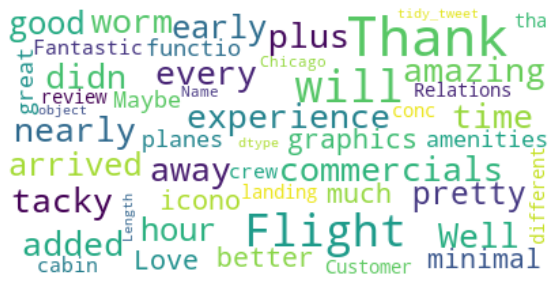

In [ ]:
# POSITIVE WORD CLOUD
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(pos_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

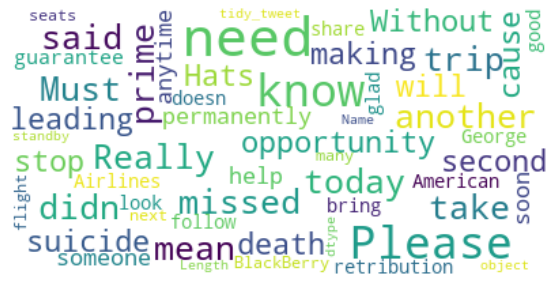

In [ ]:
# NEUTRAL WORD CLOUD
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(neu_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

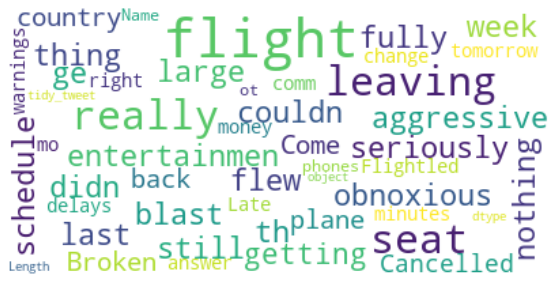

In [ ]:
# NEGATIVE WORDCLOUD
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(neg_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# DATA PREPROCESSING FOR DEEP LEARNING MODELS

In [ ]:
# Only want 2 columns that contains the tweet text and sentiment label
df[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
# Count number of each type of tweet
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
# Convert target variable to integers values
df['airline_sentiment'] = df['airline_sentiment'].replace('neutral', 1)
df['airline_sentiment'] = df['airline_sentiment'].replace('negative', 0)
df['airline_sentiment'] = df['airline_sentiment'].replace('positive', 2)

In [ ]:
# Split into text and label
X = df['text'] # data
y = df['airline_sentiment'] # labels

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# TOKENIZATION

In [ ]:
# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(X)

In [ ]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1

In [ ]:
# integer encode everything
sequences = t.texts_to_sequences(X)

In [ ]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [ ]:
tweet_num = max_tweet()
tweet_num

30

In [ ]:
# each review has a different number of words, so pad sequence with 0's
# https://realpython.com/python-keras-text-classification/
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [ ]:
# Convert labels
labels = to_categorical(np.asarray(y))

# TRAIN TEST SPLIT



In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [ ]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


# VECTORIZATION

# Pre-trained word embedding-GLOVE 

In [ ]:
# load the whole embedding into memory
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# 100 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [ ]:
# Create embedding layer using embedding matrix
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

# BUILDING OUR MODELS


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU, SimpleRNN
from tensorflow.keras.layers import BatchNormalization

MODEL 1- SIMPLE RRN

In [ ]:
model_1 = Sequential()
model_1.add(embedding_layer)
model_1.add(SimpleRNN(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
model_1.add(Dense(3, activation='softmax'))
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               91392     
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 1,669,063
Trainable params: 92,163
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_1 = model_1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 5s 50ms/step - loss: 1.1133 - acc: 0.4385 - val_loss: 1.8595 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 2s 42ms/step - loss: 0.9644 - acc: 0.5968 - val_loss: 1.3722 - val_acc: 0.6176
Epoch 3/100
37/37 [==============================] - 2s 41ms/step - loss: 0.9281 - acc: 0.6080 - val_loss: 1.3629 - val_acc: 0.6176
Epoch 4/100
37/37 [==============================] - 2s 43ms/step - loss: 0.9143 - acc: 0.6142 - val_loss: 1.2641 - val_acc: 0.6180
Epoch 5/100
37/37 [==============================] - 2s 43ms/step - loss: 0.9056 - acc: 0.6200 - val_loss: 1.1378 - val_acc: 0.6189
Epoch 6/100
37/37 [==============================] - 2s 43ms/step - loss: 0.8867 - acc: 0.6156 - val_loss: 1.0920 - val_acc: 0.6283
Epoch 7/100
37/37 [==============================] - 2s 43ms/step - loss: 0.8848 - acc: 0.6206 - val_loss: 0.9781 - val_acc: 0.6283
Epoch 8/100
37/37 [==============================] - 2s 42ms/step - loss: 0.

In [ ]:
# Find train and test accuracy
loss, accuracy = model_1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6240
Testing Accuracy:  0.6387


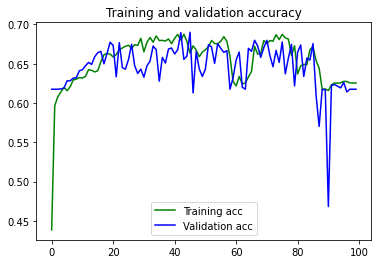

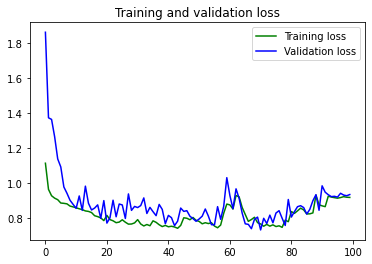

In [ ]:
# Plot train/test loss and accuracy
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MODEL 2-LSTM

In [ ]:
lstm_model2 = Sequential()
lstm_model2.add(embedding_layer)
lstm_model2.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_model2.add(Dense(3, activation='softmax'))
lstm_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_2 = lstm_model2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 8s 145ms/step - loss: 0.8307 - acc: 0.6333 - val_loss: 0.7400 - val_acc: 0.7025
Epoch 2/100
37/37 [==============================] - 5s 134ms/step - loss: 0.6856 - acc: 0.7174 - val_loss: 0.6333 - val_acc: 0.7512
Epoch 3/100
37/37 [==============================] - 5s 132ms/step - loss: 0.6493 - acc: 0.7389 - val_loss: 0.6085 - val_acc: 0.7576
Epoch 4/100
37/37 [==============================] - 5s 131ms/step - loss: 0.6226 - acc: 0.7438 - val_loss: 0.6143 - val_acc: 0.7533
Epoch 5/100
37/37 [==============================] - 5s 131ms/step - loss: 0.6147 - acc: 0.7489 - val_loss: 0.5880 - val_acc: 0.7529
Epoch 6/100
37/37 [==============================] - 5s 128ms/step - loss: 0.5958 - acc: 0.7568 - val_loss: 0.5781 - val_acc: 0.7623
Epoch 7/100
37/37 [==============================] - 5s 128ms/step - loss: 0.5765 - acc: 0.7636 - val_loss: 0.5683 - val_acc: 0.7836
Epoch 8/100
37/37 [==============================] - 5s 132ms/step - 

In [ ]:
# Find train and test accuracy
loss, accuracy = lstm_model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9542
Testing Accuracy:  0.7900


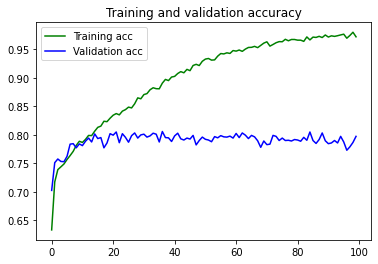

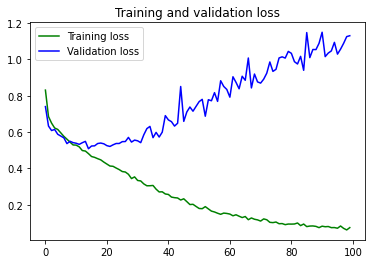

In [ ]:
# Plot train/test loss and accuracy
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MODEL 3-GRU

In [ ]:
# GRU Model 3: 
model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(GRU(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_3.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_3.add(Dense(3, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 gru (GRU)                   (None, 30, 256)           274944    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,000,455
Trainable params: 423,555
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
history_3 = model_3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 13s 248ms/step - loss: 0.8800 - acc: 0.6215 - val_loss: 0.8335 - val_acc: 0.6176
Epoch 2/100
37/37 [==============================] - 8s 225ms/step - loss: 0.7564 - acc: 0.6740 - val_loss: 0.6777 - val_acc: 0.7153
Epoch 3/100
37/37 [==============================] - 9s 230ms/step - loss: 0.6773 - acc: 0.7225 - val_loss: 0.6190 - val_acc: 0.7512
Epoch 4/100
37/37 [==============================] - 8s 230ms/step - loss: 0.6340 - acc: 0.7410 - val_loss: 0.5943 - val_acc: 0.7657
Epoch 5/100
37/37 [==============================] - 9s 236ms/step - loss: 0.5956 - acc: 0.7560 - val_loss: 0.5653 - val_acc: 0.7687
Epoch 6/100
37/37 [==============================] - 8s 228ms/step - loss: 0.5715 - acc: 0.7688 - val_loss: 0.5507 - val_acc: 0.7806
Epoch 7/100
37/37 [==============================] - 8s 227ms/step - loss: 0.5595 - acc: 0.7688 - val_loss: 0.5443 - val_acc: 0.7845
Epoch 8/100
37/37 [==============================] - 8s 230ms/step -

In [ ]:
# Find train and test accuracy
loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9562
Testing Accuracy:  0.7893


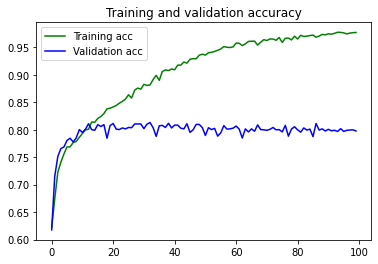

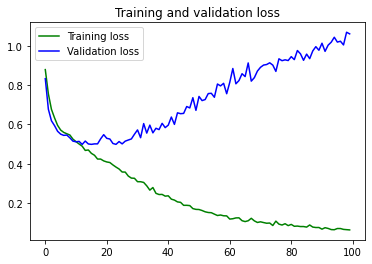

In [ ]:
# Plot train/test loss and accuracy
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


MODEL 4-BIDIRECTIONAL RNN

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
# Bidirectional RNNs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(Bidirectional(LSTM(64,
                              dropout=0.2,
                              recurrent_dropout=0.5)))
model_4.add(Dense(3,activation='softmax'))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,661,767
Trainable params: 84,867
Non-trainable params: 1,576,900
_________________________________________________________________


In [ ]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 14s 255ms/step - loss: 0.8697 - acc: 0.6103 - val_loss: 0.8049 - val_acc: 0.6389
Epoch 2/100
37/37 [==============================] - 9s 242ms/step - loss: 0.7446 - acc: 0.6908 - val_loss: 0.6913 - val_acc: 0.7277
Epoch 3/100
37/37 [==============================] - 9s 239ms/step - loss: 0.6559 - acc: 0.7342 - val_loss: 0.6191 - val_acc: 0.7478
Epoch 4/100
37/37 [==============================] - 9s 239ms/step - loss: 0.6034 - acc: 0.7556 - val_loss: 0.5841 - val_acc: 0.7691
Epoch 5/100
37/37 [==============================] - 9s 235ms/step - loss: 0.5883 - acc: 0.7605 - val_loss: 0.5779 - val_acc: 0.7734
Epoch 6/100
37/37 [==============================] - 9s 237ms/step - loss: 0.5804 - acc: 0.7632 - val_loss: 0.5570 - val_acc: 0.7755
Epoch 7/100
37/37 [==============================] - 9s 241ms/step - loss: 0.5579 - acc: 0.7737 - val_loss: 0.5524 - val_acc: 0.7840
Epoch 8/100
37/37 [==============================] - 9s 240ms/step -

In [ ]:
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9471
Testing Accuracy:  0.7811


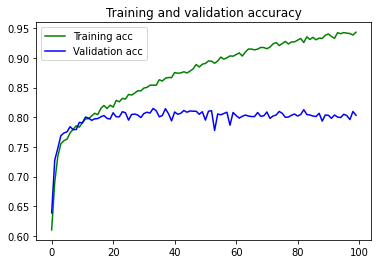

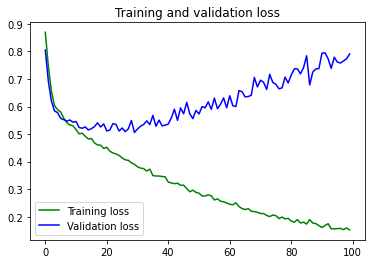

In [ ]:
acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MODEL 5-CONVOLUSION NEURAL NETWORK(CNN)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [ ]:
model_5 = Sequential()
model_5.add(embedding_layer)
model_5.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model_5.add(layers.MaxPooling1D(5))
model_5.add(layers.Conv1D(20, 4, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model_5.add(layers.GlobalMaxPooling1D())
model_5.add(layers.Dense(3,activation='softmax'))
model_5.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           1576900   
                                                                 
 conv1d (Conv1D)             (None, 25, 20)            12020     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 20)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 20)             1620      
                                                                 
 global_max_pooling1d (Globa  (None, 20)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 3)                

In [ ]:
history_5 = model_5.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
37/37 [==============================] - 10s 14ms/step - loss: 2.0352 - acc: 0.6418 - val_loss: 1.7763 - val_acc: 0.6547
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 1.5389 - acc: 0.6602 - val_loss: 1.3896 - val_acc: 0.6620
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 1.2423 - acc: 0.6762 - val_loss: 1.1785 - val_acc: 0.6731
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 1.0802 - acc: 0.6943 - val_loss: 1.0322 - val_acc: 0.7017
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 0.9921 - acc: 0.7138 - val_loss: 0.9650 - val_acc: 0.7166
Epoch 6/100
37/37 [==============================] - 0s 6ms/step - loss: 0.9350 - acc: 0.7335 - val_loss: 0.9107 - val_acc: 0.7367
Epoch 7/100
37/37 [==============================] - 0s 5ms/step - loss: 0.8930 - acc: 0.7417 - val_loss: 0.8781 - val_acc: 0.7397
Epoch 8/100
37/37 [==============================] - 0s 7ms/step - loss: 0.8629 -

In [ ]:
loss, accuracy = model_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7955
Testing Accuracy:  0.7657


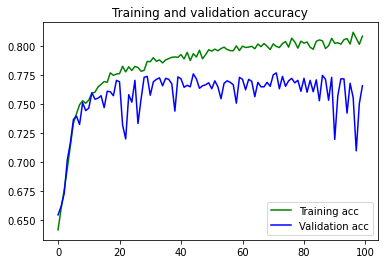

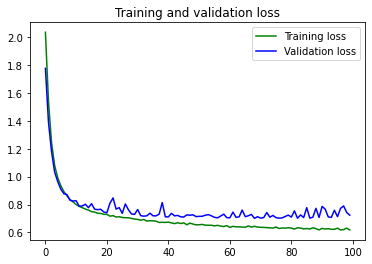

In [ ]:
acc = history_5.history['acc']
val_acc = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MODEL 6-ARTIFICIAL NEURAL NETWORK

In [ ]:
import tensorflow
model_6 = Sequential()
model_6.add(Dense(units=12673, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(units=4000, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(units=500, activation="relu"))
model_6.add(Dropout(0.5))
model_6.add(Dense(units=3, activation="softmax"))
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model_6.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
#early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

In [ ]:
history_6= model_6.fit(
    x=X_train,
    y=y_train,
    batch_size=256,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1,
    #callbacks=early_stop,
)


Epoch 1/100
46/46 [==============================] - 2s 33ms/step - loss: 165.6214 - accuracy: 0.5211 - val_loss: 1.0873 - val_accuracy: 0.6387
Epoch 2/100
46/46 [==============================] - 1s 30ms/step - loss: 1.1176 - accuracy: 0.6222 - val_loss: 1.0623 - val_accuracy: 0.6387
Epoch 3/100
46/46 [==============================] - 1s 29ms/step - loss: 1.0788 - accuracy: 0.6234 - val_loss: 1.0396 - val_accuracy: 0.6387
Epoch 4/100
46/46 [==============================] - 1s 29ms/step - loss: 1.0455 - accuracy: 0.6226 - val_loss: 1.0205 - val_accuracy: 0.6387
Epoch 5/100
46/46 [==============================] - 1s 30ms/step - loss: 1.0286 - accuracy: 0.6233 - val_loss: 1.0027 - val_accuracy: 0.6387
Epoch 6/100
46/46 [==============================] - 1s 29ms/step - loss: 1.0182 - accuracy: 0.6236 - val_loss: 0.9868 - val_accuracy: 0.6387
Epoch 7/100
46/46 [==============================] - 1s 29ms/step - loss: 0.9912 - accuracy: 0.6235 - val_loss: 0.9732 - val_accuracy: 0.6387
Epoc

In [ ]:
model_6_score = model_6.evaluate(X_test, y_test, batch_size=64, verbose=1)
print("Test accuracy:", model_6_score[1])

46/46 [==============================] - 0s 5ms/step - loss: 0.9006 - accuracy: 0.6387
Test accuracy: 0.6386612057685852


In [ ]:
loss, accuracy = model_6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6240
Testing Accuracy:  0.6387


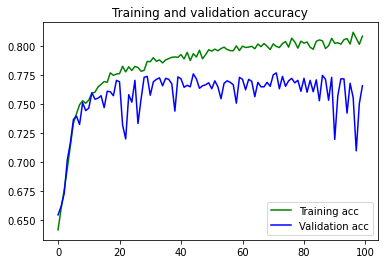

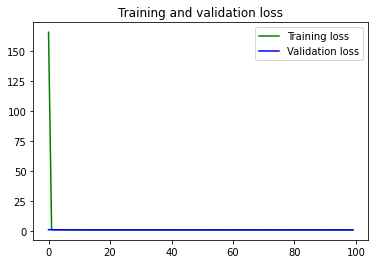

In [ ]:
accuracy= history_6.history['accuracy']
val_accuracy = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**EVALUATION OF THE BEST MODEL-GRU**

In [ ]:
pos_cnt, neg_cnt,neu_cnt, pos_correct,neg_correct, neu_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model_3.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(y_test[x]):
        if np.argmax(y_test[x]) == 0:
            neg_correct += 1
        elif np.argmax(y_test[x]) == 1:
            neu_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_test[x]) == 0:
        neg_cnt += 1
    elif np.argmax(y_test[x]) == 1:
        neu_cnt += 1
    else:
        pos_cnt += 1





1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 41ms/epoch - 41ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 30ms/epoch - 30ms/step
1/1 - 0s - 28m

In [ ]:
print("positive_acc", round(pos_correct/pos_cnt*100, 2), "%")
print("negative_acc", round(neg_correct/neg_cnt*100, 2), "%")
print("neutral_acc", round(neu_correct/neu_cnt*100, 2), "%")

positive_acc 67.12 %
negative_acc 85.45 %
neutral_acc 60.26 %


#EXTRA:HANDLING IMBALANCE WITH SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

sm = SMOTE()

X_train_samp, y_train_samp = sm.fit_resample(X_train, y_train)

In [ ]:
X_train_samp.shape, y_train_samp.shape

((21924, 30), (21924, 3))

In [ ]:
history_7 = model_3.fit(X_train_samp, y_train_samp,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Epoch 1/100
69/69 [==============================] - 19s 241ms/step - loss: 0.7490 - acc: 0.7291 - val_loss: 2.3024 - val_acc: 0.1341
Epoch 2/100
69/69 [==============================] - 16s 235ms/step - loss: 0.5231 - acc: 0.8010 - val_loss: 2.0742 - val_acc: 0.1314
Epoch 3/100
69/69 [==============================] - 16s 228ms/step - loss: 0.4669 - acc: 0.8244 - val_loss: 2.0431 - val_acc: 0.1519
Epoch 4/100
69/69 [==============================] - 18s 263ms/step - loss: 0.4427 - acc: 0.8327 - val_loss: 1.9764 - val_acc: 0.1236
Epoch 5/100
69/69 [==============================] - 16s 239ms/step - loss: 0.4053 - acc: 0.8487 - val_loss: 2.1644 - val_acc: 0.1275
Epoch 6/100
69/69 [==============================] - 16s 229ms/step - loss: 0.3875 - acc: 0.8580 - val_loss: 1.7864 - val_acc: 0.1391
Epoch 7/100
69/69 [==============================] - 16s 233ms/step - loss: 0.3620 - acc: 0.8668 - val_loss: 1.9309 - val_acc: 0.0930
Epoch 8/100
69/69 [==============================] - 16s 234ms

References

https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

https://github.com/frlim/data2040_final/tree/master/project_1

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

https://realpython.com/python-keras-text-classification/

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

https://scikit-learn.org/

https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

https://www.tensorflow.org/guide/keras/rnn